# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

The goals / steps of this project are the following:

* Load the data set (see below for links to the project data set)
* Explore, summarize and visualize the data set
* Design, train and test a model architecture
* Use the model to make predictions on new images
* Analyze the softmax probabilities of the new images
* Summarize the results with a written report

First things first, we start off my loading the necessary Python modules

In [307]:
# Load all necessary modules
import pickle
import cv2
from textwrap import wrap

import matplotlib.pyplot as plt
import numpy as np
# Visualizations will be shown in the notebook.
%matplotlib inline

import random 
import pandas as pd

import tensorflow as tf
from tensorflow.contrib.layers import flatten




---
## Step 0: Load The Data

Now we load the provided data and separate them into image and label variables

In [363]:

# Load pickled data
# TODO: Fill this in based on where you saved the training and testing data

training_file = "train.p"
validation_file="valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

Here, we will explore anbd visualize the provided data sets

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [370]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("The size of the training set is: {} Images".format(n_train))
print("The size of the validation set is: {} Images".format(n_validation))
print("The size of the test set is: {} Images".format(n_test))
print("Image data shape =", image_shape)
print("Number of unique label classes =", n_classes)

The size of the training set is: 34799 Images
The size of the validation set is: 4410 Images
The size of the test set is: 12630 Images
Image data shape = (32, 32, 3)
Number of unique label classes = 43


### Include an exploratory visualization of the dataset

In [365]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.

# Import Label Names
sfile = pd.read_csv('signnames.csv')
lbnames = sfile['SignName']
#lbnames=lbnames.iloc[::-1]
#print(len(lbnames))

In [366]:
def visualize_images(X,Y):
    """
    :param X: Image Data
    :param Y: Labels
    :return: sorted labels 
    """
    lbnums = list(set(Y))
    fig, axes = plt.subplots(8,int(np.ceil(len(lbnames)/8)), figsize =(20,20))
    fig.subplots_adjust(hspace  = 0.3, wspace = 0.05)
    im_idx = 0
    # Sort by label then grab first of each
    lbnums_sorted = sorted(range(len(Y)),key=lambda x:Y[x])
    lbnums_sorted_first = []
    track = 0
    for ind in lbnums_sorted:
        # Find first index of each label
        if y_train[ind] == track:
            lbnums_sorted_first.append(ind)
            track += 1
            if track > max(Y):
                break;
            
    for num, ax in enumerate(axes.flat):
        #im_num =
        if lbnums_sorted_first:
            ax.imshow(X[lbnums_sorted_first.pop()])
            ax.set_title("\n".join(wrap(lbnames[42-num],15)))
        ax.axis('off')
    return lbnums_sorted

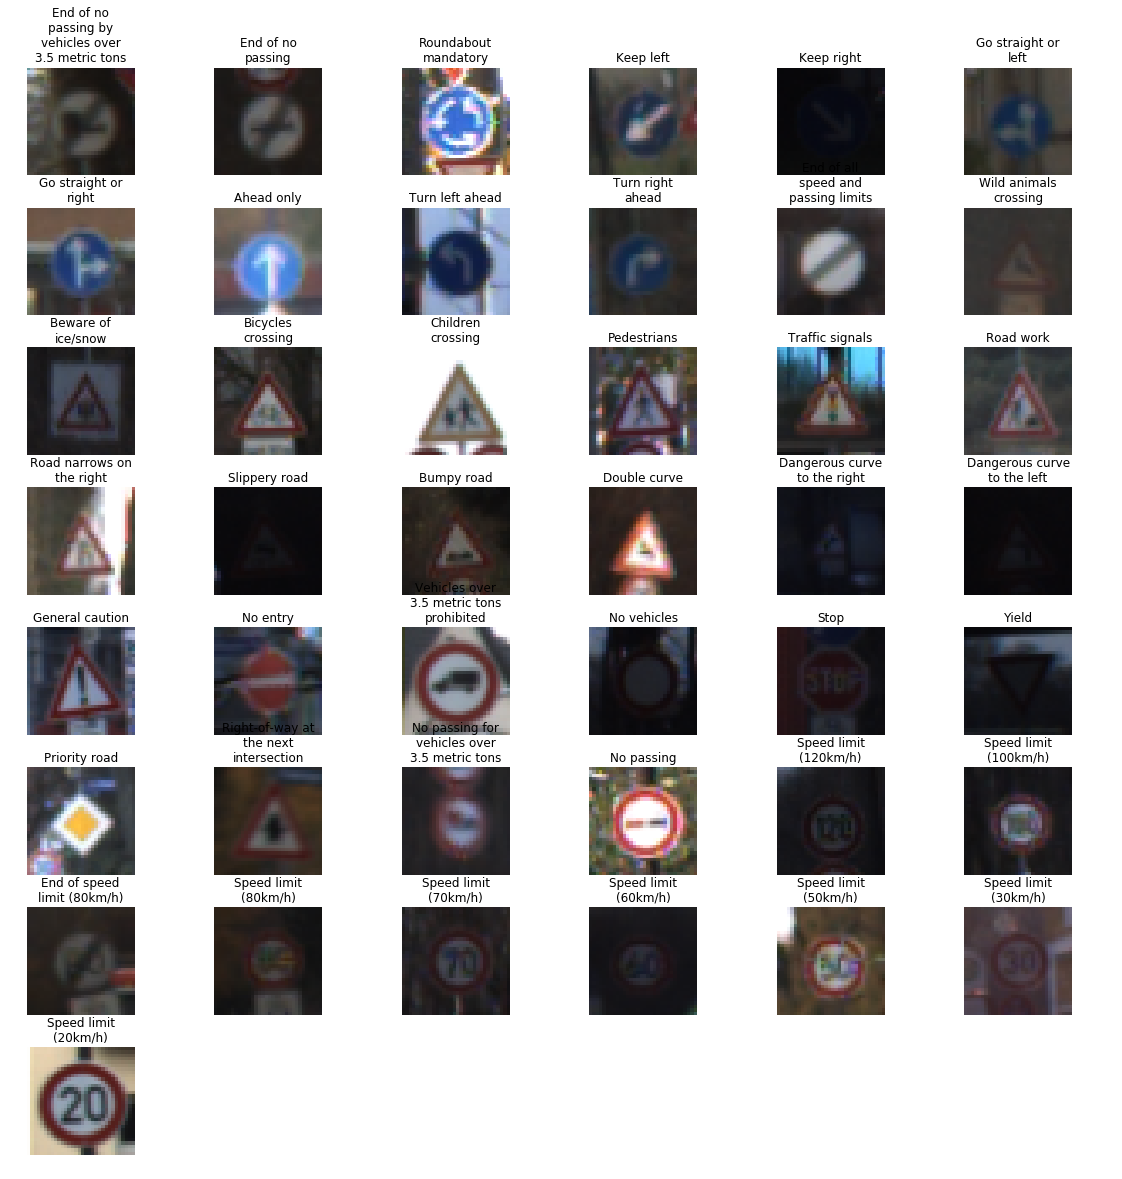

In [367]:
y_train_sorted = visualize_images(X_train,y_train)
#plt.imshow(X_train[34380])

The data appear to be in low resolution and varying brightness levels, there is also a lot of similarity between images in a given class. Data must be shuffled properly.

(array([  180.,  1980.,  2010.,  1260.,  1770.,  1650.,   360.,  1290.,
         1260.,  1320.,  1800.,  1170.,  1890.,  1920.,   690.,   540.,
          360.,   990.,  1080.,   180.,   300.,   270.,   330.,   450.,
          240.,  1350.,   540.,   210.,   480.,   240.,   390.,   690.,
          210.,   599.,   360.,  1080.,   330.,   180.,  1860.,   270.,
          300.,   210.,   210.]),
 array([  0.        ,   0.97674419,   1.95348837,   2.93023256,
          3.90697674,   4.88372093,   5.86046512,   6.8372093 ,
          7.81395349,   8.79069767,   9.76744186,  10.74418605,
         11.72093023,  12.69767442,  13.6744186 ,  14.65116279,
         15.62790698,  16.60465116,  17.58139535,  18.55813953,
         19.53488372,  20.51162791,  21.48837209,  22.46511628,
         23.44186047,  24.41860465,  25.39534884,  26.37209302,
         27.34883721,  28.3255814 ,  29.30232558,  30.27906977,
         31.25581395,  32.23255814,  33.20930233,  34.18604651,
         35.1627907 ,  36.1395

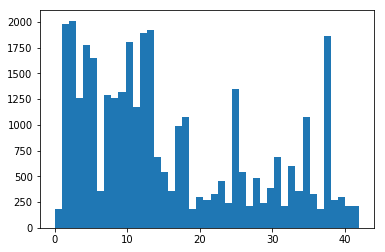

In [162]:
# Plot Histogram of Image Labels
y_train_hist, bedges = np.histogram(y_train, bins = n_classes)
plt.hist(y_train, bins=n_classes)

From the training set historgram we can see that some labels include many more examples than other. Some labels include close to 2000 examples, while others have around 250. In order to compensate for the underrepresented data, some fake data must be made.

## Step 2: Dataset Preprocessing
### Increase number of images in classes with low entries then preprocesses all the image sets

Target to have at least 500 image per class. By Perspective Scaling, Rotation, Translation. 

### Step 2.1 Define image augmentation functions

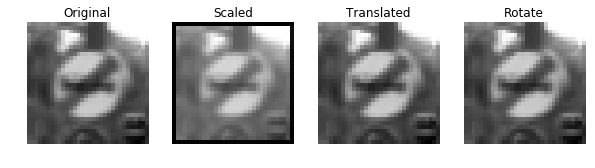

In [163]:
def findIndices(lst, a):
    return [i for i, x in enumerate(lst) if x == a]

# Convert to Grayscale
def imGrayAll(im):
    im = np.sum(im/3, axis=3, keepdims=True)
    #cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    return im

def imGray(im):
    im = np.sum(im/3, axis=2, keepdims=True)
    #cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    return im

def scale(im):
    rows,cols,ch = im.shape
    rpts = np.random.randint(-3,3)
    pts1 = np.float32([[rpts,rpts],[rows-rpts,rpts],[rpts,cols-rpts],[rows-rpts,cols-rpts]])
    pts2 = np.float32([[0,0],[rows,0],[0,cols],[rows,cols]])
    M = cv2.getPerspectiveTransform(pts1,pts2)
    im = cv2.warpPerspective(im,M,(rows,cols))
    im = im[:,:,np.newaxis]
    return im

# Test Scale 

def rotate(im):
    rows,cols,ch = im.shape
    rptsd = np.random.randint(-15,15)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),rptsd,1)
    dst = cv2.warpAffine(im,M,(cols,rows))
    #im = im[:,:,np.newaxis]
    return im

def translate(im):
    rows,cols,ch = im.shape
    rptsx = np.random.randint(-8,8)
    rptsy = np.random.randint(-8,8)
    M = np.float32([[1,0,rptsx],[0,1,rptsy]])
    dst = cv2.warpAffine(im,M,(cols,rows))
    #im = im[:,:,np.newaxis]
    return im

fig, axs = plt.subplots(1,4, figsize=(10, 3))
origImage = imGray(X_train[100])
axs[0].axis('off')
axs[0].imshow(origImage.squeeze(), cmap='gray')
axs[0].set_title('Original')

axs[1].axis('off')
axs[1].imshow(scale(origImage).squeeze(), cmap='gray')
axs[1].set_title('Scaled')

axs[2].axis('off')
axs[2].imshow(translate(origImage).squeeze(), cmap='gray')
axs[2].set_title('Translated')

axs[3].axis('off')
axs[3].imshow(rotate(origImage).squeeze(), cmap='gray')
axs[3].set_title('Rotate')

### Step 2.2 Generate Randomly Augmented Images

This the first part of data preprocessing. Existing training images are converted to grayscale, then new data is created to compensate for the underrepresented labels. I tried to pick randomly from the available images within a label class then apply random image transformations that includes scaling, rotation and translation. The result is a data set with at least 1000 images per class. 

In [164]:
%%time
X_train_aug = imGrayAll(X_train)
y_train_aug = y_train
n_augmented = 0
for label in range(n_classes):
    y_train_indices = findIndices(y_train_aug, label)
    while y_train_hist[label] < 1000:
        # Pick random index from matching labels
        indIm = random.choice(y_train_indices)
        # Generate an image from the label with random manipulation
        addim = X_train_aug[indIm]
        addim = scale(addim)
        addim = rotate(addim)
        addim = translate(addim)
        X_train_aug = np.concatenate((X_train_aug, [addim]), axis = 0)
        y_train_aug = np.concatenate((y_train_aug, [label]), axis = 0)
        y_train_hist[label] += 1
        n_augmented += 1
    print('Label: {} Done, {} new images added'.format(label, n_augmented))
    n_augmented = 0

Label: 0 Done, 820 new images added
Label: 1 Done, 0 new images added
Label: 2 Done, 0 new images added
Label: 3 Done, 0 new images added
Label: 4 Done, 0 new images added
Label: 5 Done, 0 new images added
Label: 6 Done, 640 new images added
Label: 7 Done, 0 new images added
Label: 8 Done, 0 new images added
Label: 9 Done, 0 new images added
Label: 10 Done, 0 new images added
Label: 11 Done, 0 new images added
Label: 12 Done, 0 new images added
Label: 13 Done, 0 new images added
Label: 14 Done, 310 new images added
Label: 15 Done, 460 new images added
Label: 16 Done, 640 new images added
Label: 17 Done, 10 new images added
Label: 18 Done, 0 new images added
Label: 19 Done, 820 new images added
Label: 20 Done, 700 new images added
Label: 21 Done, 730 new images added
Label: 22 Done, 670 new images added
Label: 23 Done, 550 new images added
Label: 24 Done, 760 new images added
Label: 25 Done, 0 new images added
Label: 26 Done, 460 new images added
Label: 27 Done, 790 new images added
Lab

### Save new images

In [165]:
pickle.dump( X_train_aug, open( "train_new_x.p", "wb" ) )
pickle.dump( y_train_aug, open( "train_new_y.p", "wb" ) )

### Histogram of Labels Post Augmentation 

(array([ 1000.,  1980.,  2010.,  1260.,  1770.,  1650.,  1000.,  1290.,
         1260.,  1320.,  1800.,  1170.,  1890.,  1920.,  1000.,  1000.,
         1000.,  1000.,  1080.,  1000.,  1000.,  1000.,  1000.,  1000.,
         1000.,  1350.,  1000.,  1000.,  1000.,  1000.,  1000.,  1000.,
         1000.,  1000.,  1000.,  1080.,  1000.,  1000.,  1860.,  1000.,
         1000.,  1000.,  1000.]),
 array([  0.        ,   0.97674419,   1.95348837,   2.93023256,
          3.90697674,   4.88372093,   5.86046512,   6.8372093 ,
          7.81395349,   8.79069767,   9.76744186,  10.74418605,
         11.72093023,  12.69767442,  13.6744186 ,  14.65116279,
         15.62790698,  16.60465116,  17.58139535,  18.55813953,
         19.53488372,  20.51162791,  21.48837209,  22.46511628,
         23.44186047,  24.41860465,  25.39534884,  26.37209302,
         27.34883721,  28.3255814 ,  29.30232558,  30.27906977,
         31.25581395,  32.23255814,  33.20930233,  34.18604651,
         35.1627907 ,  36.1395

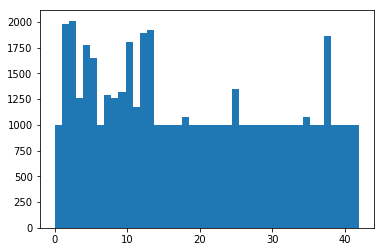

In [166]:
plt.hist(y_train_aug, bins = n_classes)

As we can see, there are at least 1000 images available per class in the training set now.

### Step 2.3 Pre-process the Data Set (normalization, grayscale, etc.)

In this preprocessing part, images are normalized using a simple normalization method. I've tried equalizing the images for better contrast. But it not affect the output. I did notice that some images are still dark and require brightness adjustment. Perhaps an adaptive histogram equalization method may be applied instead. #TODO

In [205]:
# Load from Pickle again if needed
try:
    X_train
except NameError:
    with open("train_new_x.p", mode='rb') as f:
        X_train = pickle.load(f)
    with open("train_new_y.p", mode='rb') as f:
        y_train = pickle.load(f)
    print('Trainig Images Loaded')
else:
    X_train = X_train_aug
    y_train = y_train_aug
    print('Training Images Exist Already')
                

Trainig Images Loaded


### Define Preprocessing Functions (Images Already Converted to Grayscale in 2.2)

Test Preprocessing Output


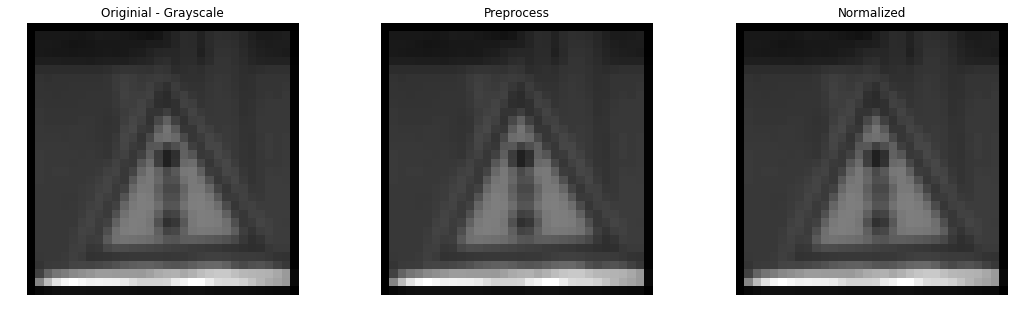

In [206]:
# Normalization
def imNorm(im):
    # quick normalization
    im = (im-128.0) / 265.0
    # L1 Normalization 
    # cv2.normalize(im,im, alpha=0, beta=1, norm_type=cv2.NORM_L1, dtype=cv2.CV_32F)
    return im

# Histogram Equalization
def imHistEq(im):
    return cv2.equalizeHist(im)

# General Preprocess Function (Define preprocess compination here, not below)
def Preprocess(im):
    #return imNormSimple(im)
    #im = imHistEq(im)
    im = imNorm(im)
    #im = im[:,:,np.newaxis]
    return im

# Test Functions
im = X_train[random.randint(0,len(y_train))]
fig, axes = plt.subplots(1,3, figsize=(18,5))
for ax in axes:
    ax.axis('off')
axes[0].imshow(im.squeeze(), cmap='gray')
axes[0].set_title('Originial - Grayscale')

#Preprocess
im_preprocess = Preprocess(im)
axes[1].imshow(im_preprocess.squeeze(), cmap='gray')
axes[1].set_title('Preprocess')

# Normalize
axes[2].imshow(imNorm(im).squeeze(), cmap='gray')
axes[2].set_title('Normalized')

#Histogram Equalization
#axes[4].imshow(imHistEq(im_gray),cmap='gray')
#axes[4].set_title('Histogram Equalization')

print('Test Preprocessing Output')

### Preprocess Images

Preprocessing Training Data



100%|██████████| 51690/51690 [00:00<00:00, 141327.40Images/s]

Done. Training Data:  (51690, 32, 32, 1)

Preprocessing Validation Data



100%|██████████| 4410/4410 [00:00<00:00, 109953.87Images/s]

Done. Validation Data:  (4410, 32, 32, 1)

Preprocessing Test Data



100%|██████████| 12630/12630 [00:00<00:00, 116879.90Images/s]

Done. Test Data:  (12630, 32, 32, 1)
CPU times: user 1.11 s, sys: 64 ms, total: 1.17 s
Wall time: 2.66 s


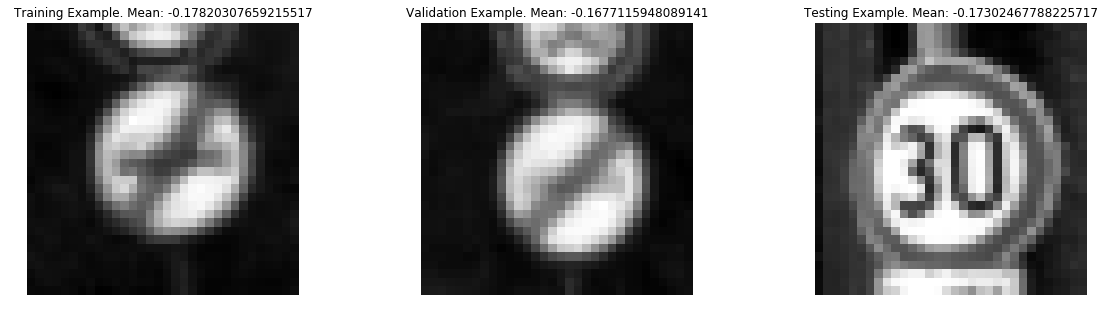

In [207]:
%%time
from tqdm import tqdm
from time import sleep 
from sklearn.utils import shuffle

#Preprocess Training Data
depthimage = 1
print('Preprocessing Training Data')
sleep(.5)
#X_train, y_train = shuffle(X_train, y_train)
progress_bar = tqdm(X_train, unit='Images')
X_train_p = np.zeros(X_train[:,:,:,:depthimage].shape)
#X_train_p = np.zeros(X_train.shape)
for ind,im in enumerate(progress_bar):
    X_train_p[ind] = Preprocess(im)
del progress_bar
y_train_p=y_train
print('Done. Training Data: ', X_train_p.shape)

#Preprocess Validation Data
print('\nPreprocessing Validation Data')
sleep(.5)
X_valid = imGrayAll(X_valid)
#X_valid, y_valid = shuffle(X_valid, y_valid)
progress_bar = tqdm(X_valid, unit='Images')
X_valid_p = np.zeros(X_valid[:,:,:,:depthimage].shape)
for ind,im in enumerate(progress_bar):
    X_valid_p[ind,:,:,:depthimage] = np.reshape(Preprocess(im),(32,32,1))
del progress_bar
y_valid_p=y_valid
print('Done. Validation Data: ', X_valid_p.shape)

#Preprocess Test Data
print('\nPreprocessing Test Data')
sleep(.5)
X_test = imGrayAll(X_test)
#X_test, y_test = shuffle(X_test, y_test)
progress_bar = tqdm(X_test, unit='Images')
X_test_p = np.zeros(X_test[:,:,:,:depthimage].shape)
for ind,im in enumerate(progress_bar):
    X_test_p[ind] = np.reshape(Preprocess(im),(32,32,1))
del progress_bar
y_test_p = y_test
print('Done. Test Data: ', X_test_p.shape)

# Display Some

fig, axes = plt.subplots(1,3, figsize=(20,5))
for ax in axes.flatten():
    ax.axis('off')
axes[0].imshow(X_train_p[1].squeeze(),cmap='gray')
axes[0].set_title('Training Example. Mean: {}'.format(np.mean(X_train_p)))
axes[1].imshow(X_valid_p[1].squeeze(),cmap='gray')
axes[1].set_title('Validation Example. Mean: {}'.format(np.mean(X_valid_p)))
axes[2].imshow(X_test_p[1].squeeze(),cmap='gray')
axes[2].set_title('Testing Example. Mean: {}'.format(np.mean(X_test_p)))




### Visualize a random set of preprocessed images one more time

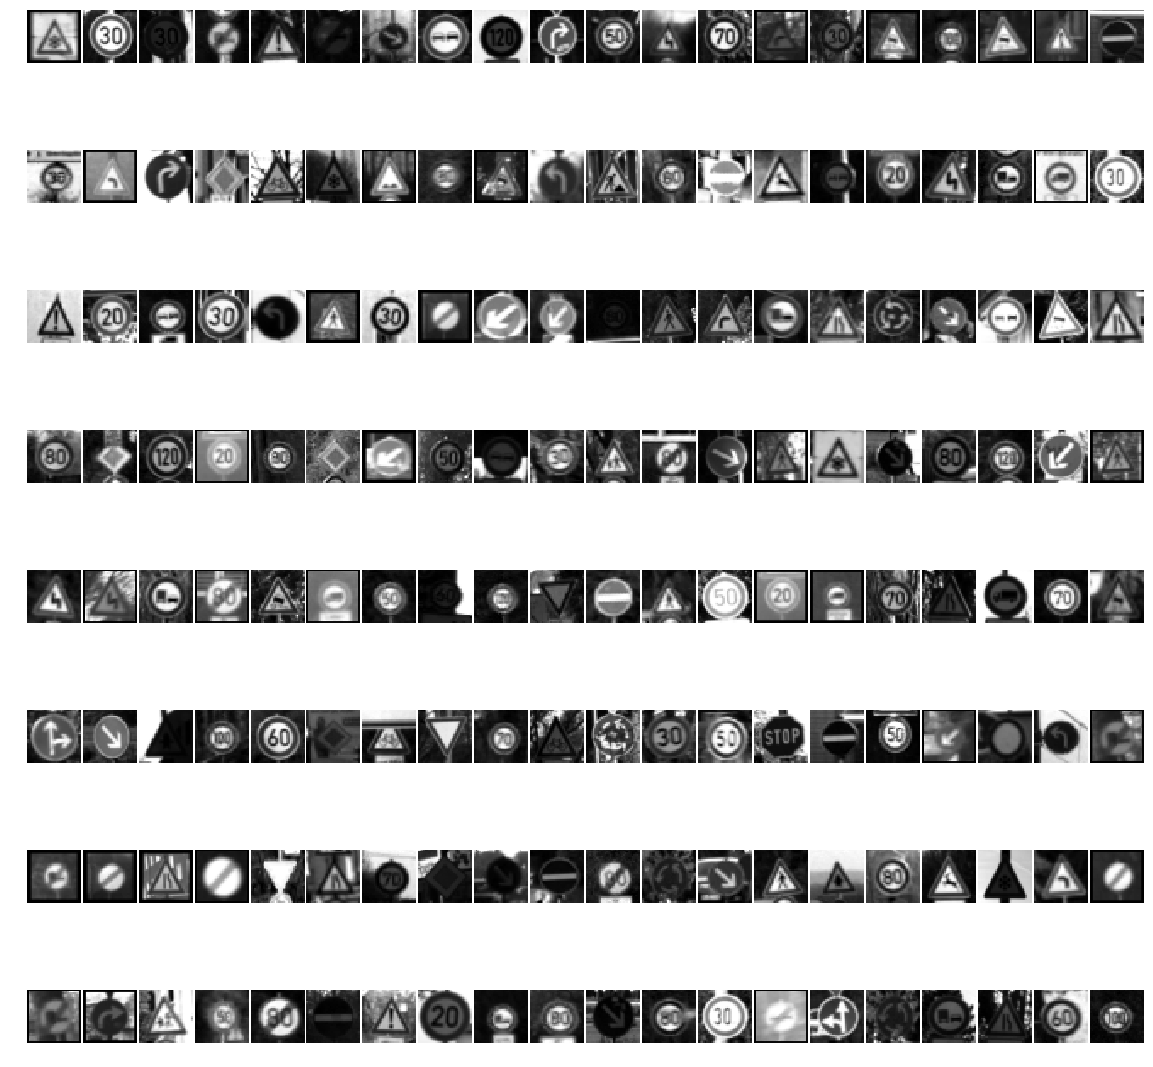

In [195]:
fig, axes = plt.subplots(8,20, figsize =(20,20))
fig.subplots_adjust(hspace  = 0.3, wspace = 0.05)
for num, ax in enumerate(axes.flat):
        im_num = random.choice(range(len(y_train_p)))
        ax.imshow(X_train_p[im_num].squeeze(),cmap='gray')
        ax.axis('off')

The above are a random sample of preprocessed training images, they are not perfect. Some have very low contrast and can't be distinguished. But let's see if the machine can see better than humans. 

### Visualize some test images

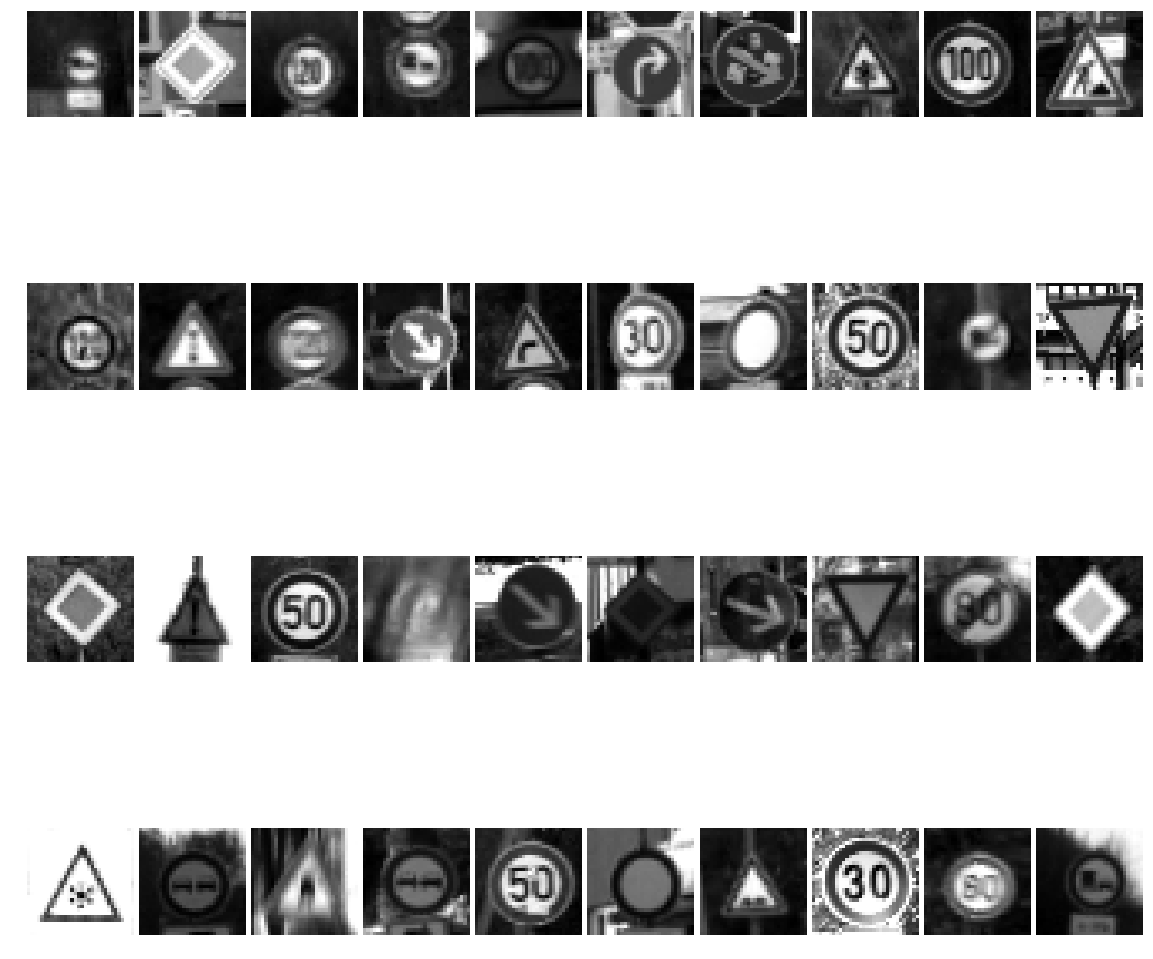

In [208]:
fig, axes = plt.subplots(4,10, figsize =(20,20))
fig.subplots_adjust(hspace  = 0.01, wspace = 0.05)
for num, ax in enumerate(axes.flat):
        im_num = random.choice(range(len(y_test_p)))
        ax.imshow(X_test_p[im_num].squeeze(),cmap='gray')
        ax.axis('off')

## Step 3: Define Tensorflow Environment and Train

I used the provided LeNeT architecture and adapted it for grayscale images and 43 labels as follows 

### 3.1 Model Architecture

Implement the LeNet-5 neural network architecture
### Input
32x32x3 image as Input for Color - 32x32x1 image for grayscale

### Architecture - Color
**Layer 1: Convolutional.** The output shape should be 28x28x8

**Activation.** 

**Pooling.** The output shape should be 14x14x8

**Layer 2: Convolutional.** The output shape should be 10x10x16

**Activation.**

**Pooling.** The output shape should be 5x5x16

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D

**Layer 3: Fully Connected.** 120 Outputs

**Activation.**

**Layer 4: Fully Connected.** 84 Outputs

**Activation.** 

**Layer 5: Fullly Connected (Logits).** 10 Outputs

### Output
Return the result of the second connected layer


In [199]:
EPOCHS = 20
BATCH_SIZE = 128

   
def LeNet(x, keep_prob):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6. 6 Filters of shape 5x5x1 
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma)) #Weights
    conv1_b = tf.Variable(tf.zeros(6)) #Bias
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6. Filter 1 : 
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2, keep_prob)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits


### 3.2 Features and Labels

In [180]:
# Reset Default Graph
tf.reset_default_graph() 

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

print('Complete')

Complete


### 3.3 Training Pipeline

In [181]:
rate = 0.001

logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

### 3.4 Model Evaluation

Evaluate loss and accuracy of the model

In [182]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data, drop_out):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: drop_out})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

print ('Complete')

Complete


### 3.5 Train

In [209]:
%%time
y_train_t, X_train_t = y_train_p, X_train_p
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_t)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_t, y_train_t = shuffle(X_train_t, y_train_t)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_t[offset:end], y_train_t[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.5})
            
        validation_accuracy = evaluate(X_valid_p, y_valid_p, drop_out=1.0)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './traffic')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.745

EPOCH 2 ...
Validation Accuracy = 0.849

EPOCH 3 ...
Validation Accuracy = 0.863

EPOCH 4 ...
Validation Accuracy = 0.896

EPOCH 5 ...
Validation Accuracy = 0.915

EPOCH 6 ...
Validation Accuracy = 0.927

EPOCH 7 ...
Validation Accuracy = 0.931

EPOCH 8 ...
Validation Accuracy = 0.933

EPOCH 9 ...
Validation Accuracy = 0.941

EPOCH 10 ...
Validation Accuracy = 0.940

EPOCH 11 ...
Validation Accuracy = 0.944

EPOCH 12 ...
Validation Accuracy = 0.944

EPOCH 13 ...
Validation Accuracy = 0.942

EPOCH 14 ...
Validation Accuracy = 0.940

EPOCH 15 ...
Validation Accuracy = 0.948

EPOCH 16 ...
Validation Accuracy = 0.948

EPOCH 17 ...
Validation Accuracy = 0.949

EPOCH 18 ...
Validation Accuracy = 0.953

EPOCH 19 ...
Validation Accuracy = 0.953

EPOCH 20 ...
Validation Accuracy = 0.952

Model saved
CPU times: user 19min 22s, sys: 20.2 s, total: 19min 43s
Wall time: 4min 3s


To train my model, I used 20 Epoch, a batch size of 128, a learning rate of 0.001. Weights starting at 0 mean and 0.1 std.

I focused on preprocessing the data further to get a better output for the validation accuracy. 
My final tests resulted in a training accuracy of 95.2%. I did not notice the validation accuracy become better with higher Epochs. A dropout of 0.5 was chosen for training. 

 - 2017.04.26 @ 4:29 - 0.955, Augmented Images 1000min per label rate 0.001, Supplied LeNet, 10 EP, 128 Batch, sigma = 0.1, mu = 0

## Step 4 Training Analysis

### 4.1 Calculate Accuracy 

In [242]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sv = tf.train.import_meta_graph('./traffic.meta')
    sv.restore(sess, "./traffic")
    prediction1 = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy1 = tf.reduce_mean(tf.cast(prediction1, tf.float32))

    testAccuracy = sess.run(
        accuracy1,
        feed_dict={x: X_test_p, y: y_test_p, keep_prob: 1.0})
    print("Test Accuracy = {:.3f}".format(testAccuracy))

Test Accuracy = 0.921


Using the provided test data set, the accuracy is 92%. It is lower than the validation accuracy, probably due to overfitting.  

### 4.2 Predict the Sign Type for Each Image

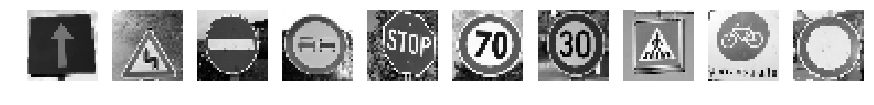

In [317]:
#Import New Images
def importimage(file):
    im = imGray(cv2.resize(cv2.imread(file),(32,32)))
    return im
newlabels = [35,21,17,9,14,4,1,27,29,15]
files =['newimages/aheadonly.jpg', 'newimages/curvyroad.jpg', 'newimages/noentry.jpg', 'newimages/nopassing.jpg',
       'newimages/stopsign.jpg', 'newimages/speed70.jpg', 'newimages/speed30.jpg', 'newimages/pedestrian.jpg',
       'newimages/bicycle.jpg','newimages/novehicles.jpg']
new_images = []
for file in files:
    new_images.append(Preprocess(importimage(file)))
    
fig, axes = plt.subplots(1,10,figsize = (15,15))
for num, ax in enumerate(axes.flat):
        ax.imshow(new_images[num].squeeze(),cmap='gray')
        ax.axis('off')

I picked up a mix of signs that are similar to the dataset and other that vary slightly. The bicycle sign for example is different than the one provided. 

Prediction: 35	- Ahead only		|	Actual: 35	 - Ahead only
Prediction: 31	- Wild animals crossing		|	Actual: 21	 - Double curve
Prediction: 17	- No entry		|	Actual: 17	 - No entry
Prediction: 9	- No passing		|	Actual: 9	 - No passing
Prediction: 17	- No entry		|	Actual: 14	 - Stop
Prediction: 4	- Speed limit (70km/h)		|	Actual: 4	 - Speed limit (70km/h)
Prediction: 1	- Speed limit (30km/h)		|	Actual: 1	 - Speed limit (30km/h)
Prediction: 18	- General caution		|	Actual: 27	 - Pedestrians
Prediction: 12	- Priority road		|	Actual: 29	 - Bicycles crossing
Prediction: 15	- No vehicles		|	Actual: 15	 - No vehicles


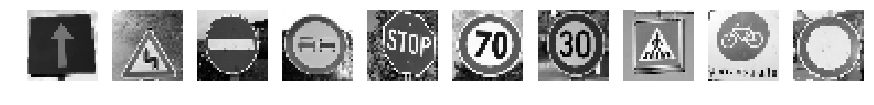

In [318]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sv3 = tf.train.import_meta_graph('./traffic.meta')
    sv3.restore(sess, "./traffic")
    prediction2 = tf.argmax(logits, 1)

    testprediction2 = sess.run(
        prediction2,
        feed_dict={x: new_images, keep_prob: 1.0})
    

#print("Test Accuracy = {:.3f}".format(testAccuracy2))
fig, axes = plt.subplots(1,10,figsize = (15,15))
for num, ax in enumerate(axes.flat):
    ax.imshow(new_images[num].squeeze(),cmap='gray')
    title = "Prediction: %d\t- %s\t\t|\tActual: %d\t - %s"%(testprediction2[num], lbnames[testprediction2[num]], newlabels[num], lbnames[newlabels[num]])
    #ax.title(repr(title))
    print(title)
    ax.axis('off')

The trained model could not predict a few signs correctly. The curvy road sign was detected as animal crossing, the stop sign as a no entry, pedestrians as general caution and bicycle crossing as priority road. The others were predicted correctly

### 4.3 Analyze Performance

In [319]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sv4 = tf.train.import_meta_graph('./traffic.meta')
    sv4.restore(sess, "./traffic")
    prediction3 = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy3 = tf.reduce_mean(tf.cast(prediction3, tf.float32))

    testAccuracy3 = sess.run(
        accuracy3,
        feed_dict={x: new_images, y: newlabels, keep_prob: 1.0})
    print("Test Accuracy = {:.3f}".format(testAccuracy3))

Test Accuracy = 0.600


The accuracy on the new found images is only 60%

### 4.4 Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [334]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
sfno = 5

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sv5 = tf.train.import_meta_graph('./traffic.meta')
    sv5.restore(sess, "./traffic")
    prediction4 = tf.nn.softmax(logits)

    testprediction4 = sess.run(tf.nn.top_k(
        prediction4, k = sfno),
        feed_dict={x: new_images, keep_prob: 1.0})
print('Complete')

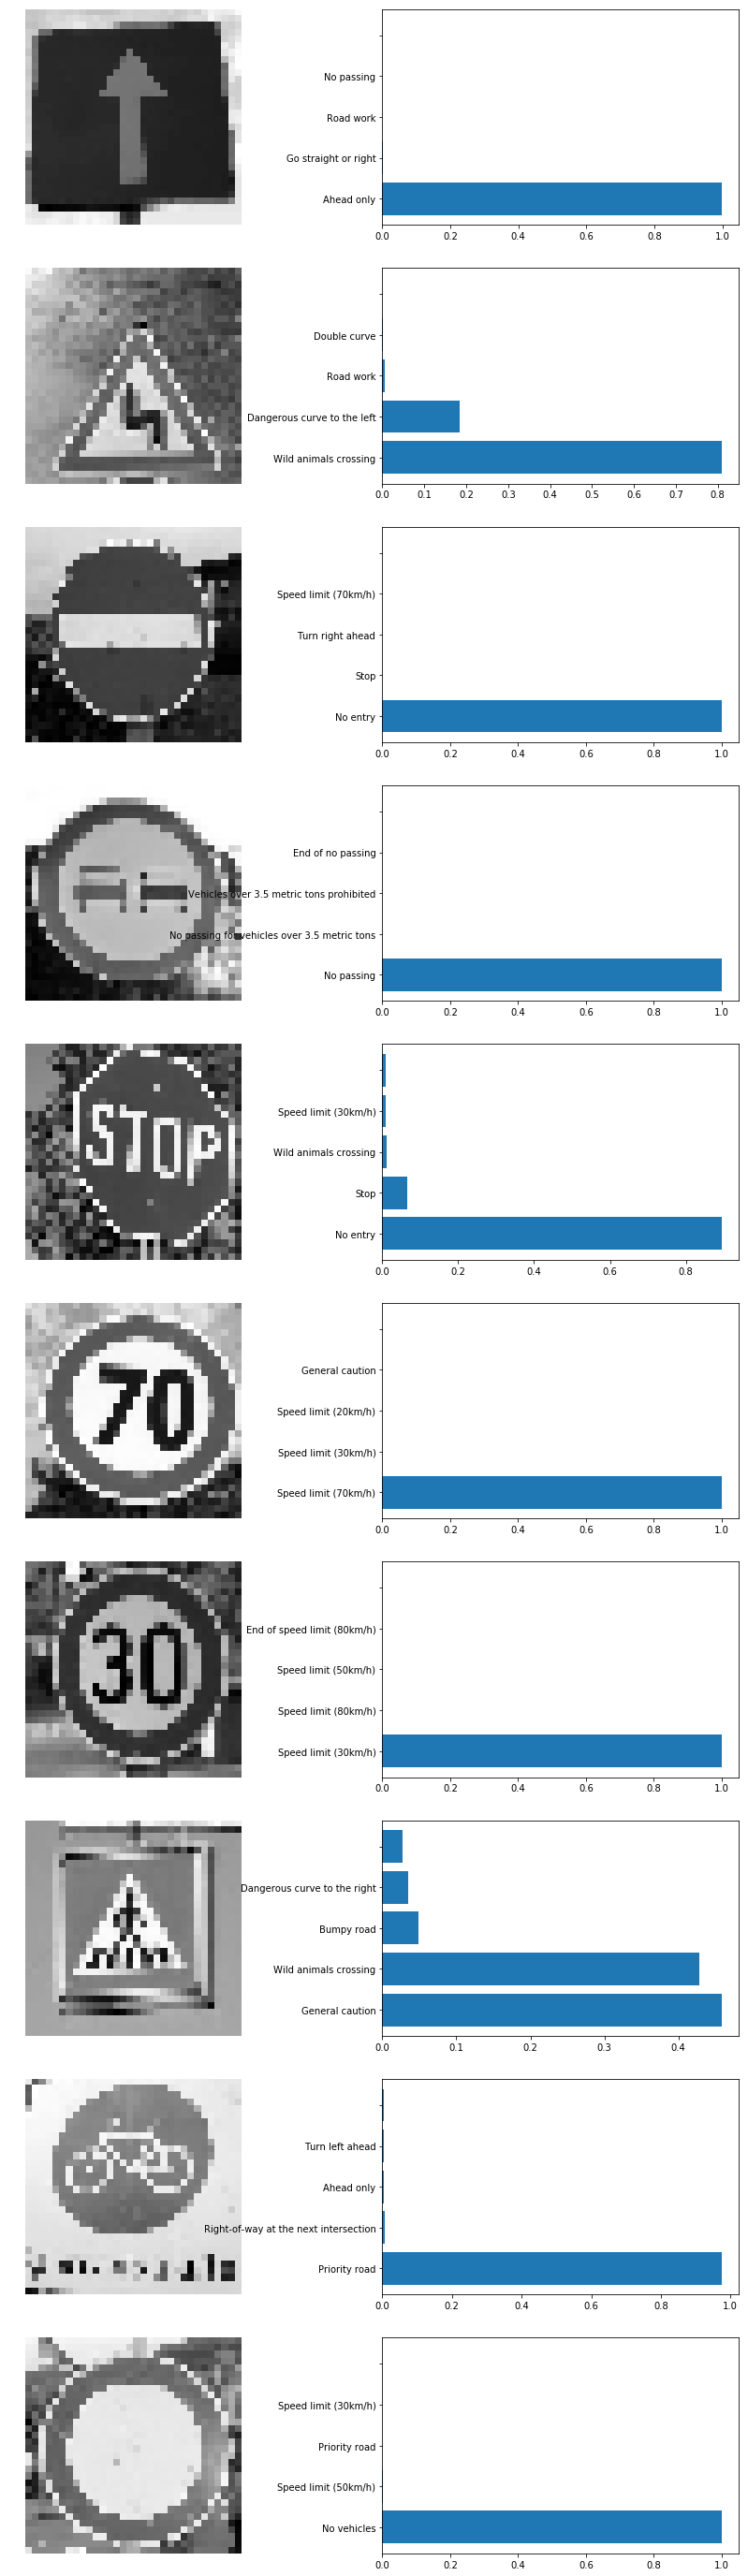

In [357]:
smprobabilities, smpredictions = testprediction4
sfrange = np.arange(sfno)
fig, axes = plt.subplots(10,2,figsize = (15,50))
for num, ax in enumerate(axes.flat):
    if num % 2 == 0:
        ax.imshow(new_images[num//2].squeeze(),cmap='gray')
        ax.axis('off')
    else: 
        ind = (num-1)//2
        #ylabels 
        ax.barh(sfrange, smprobabilities[ind])
        ax.set_yticklabels([lbnames[(smpredictions[ind][i-1])] for i in sfrange] )

For those images the were predicted correclty, the model has a very high (100%) confidence in the prediction. For those that the trained model got wrong, the situation varies. With the bicycle image, the model is very confident it is a priority road sign and it, along with the pedestrian crossing did not have their actual labels even considered in the top 5.

To summarize, I believe further image preprocessing can help improve the training data, especially on thoese images with low contrast and brightness. A different model architecture can perhaps bring better results. The class video showed that the LeNet results in around 96% validation accuracy using the colored images without much preprocessing. This will certainly take more training time, but it would make more sense since using a colored image means more data is fed into training the model. 

This is my very first project dealing with machine learning, it was a good stepping stone for me and for brushing up my rusty python skills. 